In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from collections import defaultdict
from torch.autograd import Variable
import gc
import sys
import os
import time
#gc.set_debug(gc.DEBUG_STATS)
%matplotlib inline

In [24]:
data = []
j = 0
k = 0
for l in open('input.txt'):
    if '<start>' in l:
        data.append('$')
        j += 1
    elif '<end>' in l:
        data.append('%')
        k += 1
    else:
        for c in range(len(l)):
            data.append(l[c])
    #data.append('\n')
print(j)
print(k)

1124
1124


In [28]:
unique_char = defaultdict(int)
j_ = 0
k_ = 0
for d in data:
    if d == '$':
        j_ += 1
    elif d == '%':
        k_ += 1
    unique_char[d] += 1
#print(len(unique_char))
i = 0
char_idx = defaultdict(int)
for k in unique_char:
    char_idx[k] = i
    i += 1
    
idx_char = defaultdict(str)
for k in char_idx:
    idx_char[char_idx[k]]=k
#print(idx_char)

dat = np.arange(len(char_idx))
len(char_idx)
#char_idx
#print(j_,k_)

95

In [29]:
def one_hot_encoder(char_idx,data):
    output = []
    for i in range(len(data)):
        aux = np.zeros(len(char_idx))
        aux[char_idx[data[i]]] = 1
        output.append(aux.copy())
    return output

def softmaxT(data,T=1):
    temp = torch.exp(data/T)
    aux = torch.sum(temp)
    return temp/aux

In [30]:
oh_data = one_hot_encoder(char_idx,data)

In [31]:
input_data = []
output_data = []
for i in range(len(oh_data)-1):
    input_data.append(oh_data[i].copy())
    output_data.append(oh_data[i+1].copy())
print(len(input_data))
print(len(output_data))
#print(input_data[0],output_data[0])
#print(input_data[1],output_data[1])

487982
487982


In [32]:
split_ratio = 0.8
X_train = input_data[:int(split_ratio*len(input_data))]
Y_train_aux = output_data[:int(split_ratio*len(input_data))]
X_valid = input_data[int(split_ratio*len(input_data)):]
Y_valid_aux = output_data[int(split_ratio*len(input_data)):]
Y_train = []
Y_valid = []
for i in range(len(Y_train_aux)):
    Y_train.append(np.argmax(Y_train_aux[i]))
for i in range(len(Y_valid_aux)):
    Y_valid.append(np.argmax(Y_valid_aux[i]))
print(len(X_train),len(Y_train))
print(len(X_valid),len(Y_valid))

390385 390385
97597 97597


In [33]:
class LSTMMusic(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,num_layers,batch_size=1):
        super(LSTMMusic,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = torch.nn.LSTM(self.input_dim,self.hidden_dim,self.num_layers)
        self.fc = torch.nn.Linear(self.hidden_dim,self.output_dim)
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
#         return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim)),
#                Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim)))
        return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim).cuda()),
               Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim).cuda()))
    
    def del_hidden(self):
        del self.hidden
        self.hidden = self.init_hidden()
        
    def forward(self,sequence):
        out, _ = self.lstm(sequence.view(len(sequence),self.batch_size,-1),self.hidden)
        out = self.fc(out)
        return out

-- 0 4.528491497039795
-- 97575 0.8822983503341675
-- 195150 1.0945721864700317
-- 292725 2.520526647567749
-- 390300 0.896680474281311
0 Train Loss :  0.0834025777141501 Val Loss :  2.291989717094906e-05


/opt/conda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMMusic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


-- 0 2.9605157375335693
-- 97575 0.2591272294521332
-- 195150 0.906808078289032
-- 292725 2.231062889099121
-- 390300 0.8036314249038696
1 Train Loss :  0.06692902570188657 Val Loss :  2.1794543986508744e-05
-- 0 2.688657522201538
-- 97575 0.20915649831295013
-- 195150 0.7970804572105408
-- 292725 2.095024347305298
-- 390300 0.7901940941810608
2 Train Loss :  0.062424258923581194 Val Loss :  2.0922901862549295e-05
-- 0 2.7446792125701904
-- 97575 0.18990188837051392
-- 195150 0.7606828808784485
-- 292725 2.0186963081359863
-- 390300 0.7871227860450745
3 Train Loss :  0.059966926068664536 Val Loss :  2.0324487034492316e-05
-- 0 2.7156968116760254
-- 97575 0.1719001829624176
-- 195150 0.7235561609268188
-- 292725 1.9736844301223755
-- 390300 0.7924673557281494
4 Train Loss :  0.05832974155625366 Val Loss :  1.9835793317443434e-05
-- 0 2.745720148086548
-- 97575 0.1700238585472107
-- 195150 0.6821621656417847
-- 292725 1.9203921556472778
-- 390300 0.8276264071464539
5 Train Loss :  0.0570

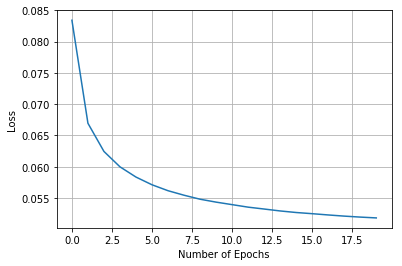

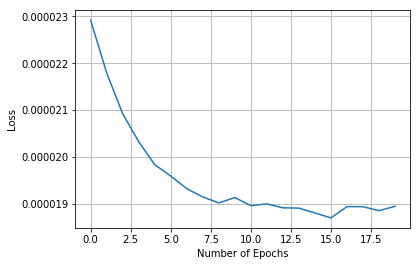

In [37]:
INPUT_DIM = len(char_idx)
OUTPUT_DIM = len(char_idx)
HIDDEN_DIM = 100
BATCH_SIZE = 1
NUM_LAYERS = 1
char_size = 25
epochs = 20

model = LSTMMusic(INPUT_DIM,HIDDEN_DIM,OUTPUT_DIM,NUM_LAYERS,BATCH_SIZE)
model.cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

eps = []
tr_loss = []
va_loss = []
model.hidden = model.init_hidden()

ts = time.time()
for epoch in range(epochs):
    tot_loss = 0
    val_loss = 0
    i = 0
    #gc.collect()
    #print(i,sys.getsizeof(model))
    #model.hidden = model.init_hidden()
    l = open('./observations/lstm_music_trial_'+str(ts)+'.txt','a+')
    while i < len(X_train):
        #print(i)
#         if i%1000 == 0:
#             gc.collect()
        inputs = X_train[i:min(i+char_size,len(X_train))]
        outputs = Y_train[i:min(i+char_size,len(X_train))]
#         outputs = []
#         for j in range(len(inputs)):
#             outputs.append(np.argmax(outputs_aux[j]))
        optimizer.zero_grad()
        #model.hidden = model.init_hidden()

        #ip = Variable(torch.from_numpy(np.array(inputs)).float())
        ip = Variable(torch.from_numpy(np.array(inputs)).float().cuda())
        del inputs
        op = torch.from_numpy(np.array(outputs))
        #op = Variable(op.type(torch.LongTensor))
        op = Variable(op.type(torch.LongTensor).cuda())
        del outputs
        out = model(ip)
        out = out.view(out.data.shape[0],out.data.shape[2])
        #print(out.shape)
        #print(op.shape)
        loss = loss_fn(out,op)
        del ip, op, out
        loss.backward()
        optimizer.step()
        tot_loss += float(loss.cpu().data.numpy())
        if i%(int(len(X_train)/100)) == 0:
            print('--',i,loss.data[0])
        i += char_size
    
    #for k in range(len(X_valid)):
    inputs = X_valid
    outputs = Y_valid
    #print(outputs_v)
    #ip = Variable(torch.from_numpy(np.array(inputs)).float())
    ip = Variable(torch.from_numpy(np.array(inputs)).float().cuda())
    #ip = ip.view(len(ip),-1)
    #print(ip.shape)
    op = torch.from_numpy(np.array(outputs))
    #op = Variable(op.type(torch.LongTensor))
    op = Variable(op.type(torch.LongTensor).cuda())
    del inputs, outputs
    #print(op.shape)
    out = model(ip)
    out = out.view(out.data.shape[0],out.data.shape[2])
#         print(out_v.shape)
#         print(op_v.shape)
    loss = loss_fn(out,op)
    del ip, op, out
    val_loss += float(loss.cpu().data.numpy())
    #model.del_hidden()
    print(epoch,'Train Loss : ',tot_loss/len(X_train),'Val Loss : ',val_loss/len(X_valid))
    eps.append(epoch)
    tr_loss.append(tot_loss/len(X_train))
    va_loss.append(val_loss/len(X_valid))
    l.write(str(epoch)+' T '+str(tot_loss/len(X_train))+' V '+str(val_loss/len(X_valid))+'\n')
    l.close()
    if os.path.exists('saved_models/modelv1.0.pt'):
        os.remove('saved_models/modelv1.0.pt')
    torch.save(model,'saved_models/modelv1.0.pt')

plt.plot(eps,tr_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.plot(eps,va_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [43]:
prefix = '<start>\nX'
# prefix = '<'
pref_oh = one_hot_encoder(char_idx,prefix)

#ip = Variable(torch.from_numpy(np.array(pref_oh)).float())
ip = Variable(torch.from_numpy(np.array(pref_oh)).float().cuda())
out = model(ip)
final_out = out[-1,:,:]
dist = softmaxT(final_out.data).cpu().numpy()
dist = dist.reshape(dist.shape[1])
seq_len = 100
output = []
prev_char = np.random.choice(dat,p=dist)
output.append(prev_char)
#output.append(char_idx['M'])
for i in range(seq_len):
    x = prev_char
    #print(dist)
    #output.append(x)
    ip = np.zeros((1,len(char_idx)))
    ip[0,x]=1
    #ip = Variable(torch.from_numpy(np.array(ip)).float())
    ip = Variable(torch.from_numpy(np.array(ip)).float().cuda())
    out = model(ip)
    aux = softmaxT(out[-1,:,:].data).cpu().numpy()
    aux = aux.reshape(aux.shape[1])
    prev_char = np.random.choice(dat,p=aux)
    output.append(prev_char)

output_seq = []
for i in range(len(output)):
    output_seq.append(idx_char[output[i]])
#print(output_seq)

[':', '|', 'g', '/', 'A', 'F', 'G', 'E', 'F', 'A', '|', 'E', 'l', 'e', ' ', 'd', 'd', 'e', '\n', 'a', 'n', 'c', 'h', 'a', 't', 'h', 'n', 'n', '-', '2', 'a', '/', 'A', 'G', ' ', 'd', '.', 'e', 'f', 'r', 'e', ':', '|', '~', 'G', '|', 'a', 'f', 'a', ' ', 'G', '2', ' ', 'f', 'g', '|', '\n', 'X', ':', 'I', 'C', 'h', 'n', 't', 'e', 'c', 'A', 'F', ' ', 'H', ':', 'T', 'o', 'v', 'i', 't', 'i', 'l', 'y', '\n', 'X', ':', 'J', 'o', 'l', 'o', 'b', 'a', 'a', 'f', 'e', '.', '\n', 'T', ':', '1', '\n', '<', 's', 't', '>']


In [38]:
model2 = torch.load('saved_models/modelv1.0.pt')

In [47]:
prefix = '$'
T = 0.7
pref_oh = one_hot_encoder(char_idx,prefix)

#ip = Variable(torch.from_numpy(np.array(pref_oh)).float())
ip = Variable(torch.from_numpy(np.array(pref_oh)).float().cuda())
out = model2(ip)
final_out = out[-1,:,:]
dist = softmaxT(final_out.data,T).cpu().numpy()
dist = dist.reshape(dist.shape[1])
seq_len = 800
output = []
prev_char = np.random.choice(dat,p=dist)
output.append(prev_char)
#output.append(char_idx['M'])
for i in range(seq_len):
    x = prev_char
    #print(dist)
    #output.append(x)
    ip = np.zeros((1,len(char_idx)))
    ip[0,x]=1
    #ip = Variable(torch.from_numpy(np.array(ip)).float())
    ip = Variable(torch.from_numpy(np.array(ip)).float().cuda())
    out = model2(ip)
    aux = softmaxT(out[-1,:,:].data,T).cpu().numpy()
    aux = aux.reshape(aux.shape[1])
    prev_char = np.random.choice(dat,p=aux)
    output.append(prev_char)

output_seq = []
for i in range(len(output)):
    output_seq.append(idx_char[output[i]])
#print(output_seq)

gen_text = ''
for i in output_seq:
    if i == '\n':
        print(gen_text)
        gen_text = ''
    else:
        gen_text = gen_text + str(i)
print(gen_text)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


X:FEFA|
GEEA cdare dg/F/BAcA|
%$X: cde AFAFA, Bd|dBefedcBA/g GBABd acd B|dfgathn-4:|d arrefanolkaturcA2dBdg2d aferbaithee c AGEG2g BcAls c'vecAG4
Merig BAFA2GA| A ABAd2 B,GE2A3
K:Sc/(3c|
R: | d|2ABcA DB GBABGG T:|fg3
|c2Ac ||
T:T: ed|1 G||
M:A mied BAF BGEABG3
Z: GAB|: (3dfg/arn:insinth de D2 B/80
T:ED, alelefag2d bc enag2 Aceedelkagd BdBAFA Ch#5
fg|:|alag2GFABG~AGEgag AFABABG2 B2AB||
M:| |
St |
K:C:igefffgefalals.
Sthee |:GEF|
B|| ef G2 BcBA A GEAdBA2 ThecABA A2 alkanathe
D|
T:P:inw:||
Z:|1 bagf Mefan af Arie
%$X:P:ithnarra A/dg2A (3cABAn-4
K:|:||
T:|:|fgbalun:|A2 ~BAd AGBdcd2B|
(1 Bc'sen Bd/81 T:T:1 (3cAG c e2: (3
D2 d2A ffe|
Mig/ c|
P:"B2BGFGABd A celsc d:Thor M:Ce fd gfdBA T:|
K:Th, "DE|||BA (3gf2 d dcd|:C:A|
|
R: AGEFAFG2dB d2E GEFEFD pilt cd2delee B~GAGGB atrinthed c=c/|:g3 cAG/4
Mede
